In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sbi import utils as sbi_utils
from sbi import inference as sbi_inference
from sbi.inference import simulate_for_sbi
from sbi.analysis import plot_summary
from sbi.analysis import pairplot
import pymc as pm
import arviz as az
import seaborn as sns
import pandas as pd


In [2]:
def compute_ci(samples, level=0.95):
    lower = (1.0 - level) / 2.0
    upper = 1.0 - lower
    q = torch.tensor([lower, upper], dtype=samples.dtype, device=samples.device)
    return torch.quantile(samples, q, dim=0)

def better_pairplot(samples, theta_true=None, method_name="SBI"):
    import seaborn as sns
    import pandas as pd

    samples_np = samples.numpy()
    df = pd.DataFrame(samples_np, columns=["Slope (m)", "Intercept (c)"])

    # Compute confidence intervals
    ci = compute_ci(samples)

    g = sns.pairplot(df, kind="hist", corner=True, plot_kws=dict(alpha=0.3, color="C0"))
    
    # Annotate each marginal with CI lines and text
    for i, param in enumerate(["Slope (m)", "Intercept (c)"]):
        ax = g.axes[i, i]
        # CI lines
        ax.axvline(ci[0, i].item(), color="orange", linestyle="--", linewidth=1.5)
        ax.axvline(ci[1, i].item(), color="orange", linestyle="--", linewidth=1.5)
        # True value
        if theta_true is not None:
            ax.axvline(theta_true[i].item(), color="black", linestyle="--", linewidth=1)

        # CI text annotation
        #ci_text = f"95% CI:\n[{ci[0,i]:.2f}, {ci[1,i]:.2f}]"
        #ax.text(0.05, 0.85, ci_text, transform=ax.transAxes, fontsize=9,
                #verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))

    # Joint plot marker + lines for truth
    if theta_true is not None and len(theta_true) == 2:
        ax_joint = g.axes[1, 0]
        ax_joint.axvline(theta_true[0].item(), color='black', linestyle='--', linewidth=1)
        ax_joint.axhline(theta_true[1].item(), color='black', linestyle='--', linewidth=1)
        ax_joint.plot(theta_true[0].item(), theta_true[1].item(), 'kx', markersize=6)

    g.fig.suptitle(f"{method_name} Posterior Pairplot with 95% CI", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()



def run_experiment(
    theta_true=torch.tensor([3.6, -4.4]), # True parameters (m, c)
    sigma_noise=0.1,                      # Observation noise
    n_grid=20,                            # Number of x-points
    x_domain=(-1.0, 1.0),                 # Range of x-values
    prior_bounds=(-10.0, 10.0),           # Uniform prior bounds
    num_simulations=2000,                 # SBI simulations
    num_posterior_samples=10000,          # Posterior samples
    plot=True                              # Toggle plotting
):
    # Setup environment
    device = torch.device('cpu')
    torch.manual_seed(32)
    #np.random.seed(0)
    x_grid = torch.linspace(x_domain[0], x_domain[1], n_grid).to(device)
    prior_low = torch.tensor([prior_bounds[0]] * 2).to(device)
    prior_high = torch.tensor([prior_bounds[1]] * 2).to(device)
    prior = sbi_utils.BoxUniform(low=prior_low, high=prior_high)
    
    # Simulator
    def simulator(theta, x_grid, sigma_noise):
        m, c = theta[..., 0], theta[..., 1]
        noise = torch.randn_like(x_grid) * sigma_noise
        # Always use the same noise pattern
        #fixed_noise = torch.linspace(-1, 1, len(x_grid)) * sigma_noise  # or any fixed pattern
        return m[..., None] * x_grid + c[..., None] + noise


    # Analytic solution fucntion
    def analytic_posterior(x_grid, y_obs, sigma_noise, prior_low, prior_high):
        var_uniform = ((prior_high - prior_low) ** 2) / 12.0
        Sigma0 = torch.diag(var_uniform)
        Sigma0_inv = torch.inverse(Sigma0)
        X_mat = torch.stack([x_grid, torch.ones_like(x_grid)], dim=1)
        Sigma_post_inv = Sigma0_inv + (1.0 / sigma_noise**2) * X_mat.T @ X_mat
        Sigma_post = torch.inverse(Sigma_post_inv)
        mu_post = Sigma_post @ (
            Sigma0_inv @ torch.zeros(2) + (1.0 / sigma_noise**2) * X_mat.T @ y_obs
        )
        return mu_post, Sigma_post
        
    # MCMC function
    def mcmc(x_grid, y_obs, sigma_noise):    
        x_np = x_grid.cpu().numpy()
        y_np = y_obs.cpu().numpy()
        with pm.Model() as model:
            m = pm.Uniform("m", lower=prior_bounds[0], upper=prior_bounds[1])
            c = pm.Uniform("c", lower=prior_bounds[0], upper=prior_bounds[1])
            y_est = m * x_np + c
            y_like = pm.Normal("y_like", mu=y_est, sigma=sigma_noise, observed=y_np)
            trace = pm.sample(2000, tune=1000, chains = 4, cores=2, return_inferencedata=True, progressbar=True)
            mcmc_samples = trace.posterior.stack(samples=("chain", "draw"))
            mcmc_m = mcmc_samples["m"].values.flatten()
            mcmc_c = mcmc_samples["c"].values.flatten()
        
        return torch.tensor(np.vstack([mcmc_m, mcmc_c]).T)
        
    # Generate observed data
    sim_wrapper = lambda theta: simulator(theta, x_grid, sigma_noise)
    with torch.no_grad():
        y_obs = sim_wrapper(theta_true)
    
    # Run SBI
    #grid_size = int(num_simulations**0.5)
    #m_vals = torch.linspace(prior_bounds[0], prior_bounds[1], grid_size)
    #c_vals = torch.linspace(prior_bounds[0], prior_bounds[1], grid_size)
    #m_grid, c_grid = torch.meshgrid(m_vals, c_vals, indexing="ij")
    #thetas = torch.stack([m_grid.flatten(), c_grid.flatten()], dim=1)

    #xs = torch.stack([sim_wrapper(theta) for theta in thetas])

    thetas, xs = simulate_for_sbi(sim_wrapper, prior, num_simulations=num_simulations)
    inference = sbi_inference.NPE(prior=prior)
    density_estimator = inference.append_simulations(thetas, xs).train()
    posterior = inference.build_posterior(density_estimator)
    posterior_samples = posterior.sample((num_posterior_samples,), x=y_obs)
    
    # Analytic solution
    mu_post, Sigma_post = analytic_posterior(x_grid, y_obs, sigma_noise, prior_low, prior_high)
    analytic_samples = torch.distributions.MultivariateNormal(mu_post, Sigma_post).sample((num_posterior_samples,))
    
    # MCMC
    mcmc_samples = mcmc(x_grid, y_obs, sigma_noise)
    
    # Plotting
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
        
        # Left plot: Parameter space
        ax[0].scatter(posterior_samples[:, 0], posterior_samples[:, 1], alpha=0.1, label="SBI", color="b", marker='.')
        ax[0].scatter(analytic_samples[:, 0], analytic_samples[:, 1], alpha=0.1, label="Analytic", color="g", marker='.')
        if mcmc_samples is not None:
            ax[0].scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], alpha=0.1, label="MCMC", color="r", marker='.')
        ax[0].scatter([theta_true[0]], [theta_true[1]], marker='x', s=100, label="Truth", color="k")
        ax[0].set_xlabel(r"Slope ($m$)")
        ax[0].set_ylabel(r"Intercept ($c$)")
        ax[0].set_title("Parameter space (Analytic vs MCMC vs SBI)")
        ax[0].legend()
        
        # Right plot: Posterior predictions
        x_dense = torch.linspace(x_domain[0]-0.2, x_domain[1]+0.2, 100)
        m0, c0 = posterior_samples[0]
        ax[1].plot(x_dense, m0 * x_dense + c0, alpha=0.05, label="SBI posterior samples", color="c")
        for i in range(200):
            m, c = posterior_samples[i]
            ax[1].plot(x_dense, m * x_dense + c, alpha=0.05, color="c")
        ax[1].scatter(x_grid, y_obs, label="Observed data", color="m")
        ax[1].plot(x_dense, theta_true[0] * x_dense + theta_true[1], label="Truth", color="k")
        ax[1].set_xlabel(r"$x$")
        ax[1].set_ylabel(r"$y$")
        ax[1].set_title("Possible regression lines from the SBI posterior")
        ax[1].legend()
        
        plot_summary(inference)
        plt.tight_layout()
        plt.show()
        
        
        better_pairplot(posterior_samples, theta_true=theta_true, method_name="SBI")
        better_pairplot(analytic_samples, theta_true=theta_true, method_name="Analytic")
        better_pairplot(mcmc_samples, theta_true=theta_true, method_name="MCMC")






  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 189 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/kattheod/Documents/py4e/MachineLearning /sbi-logs/NPE_C/2025-05-24T22_02_29.181073' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


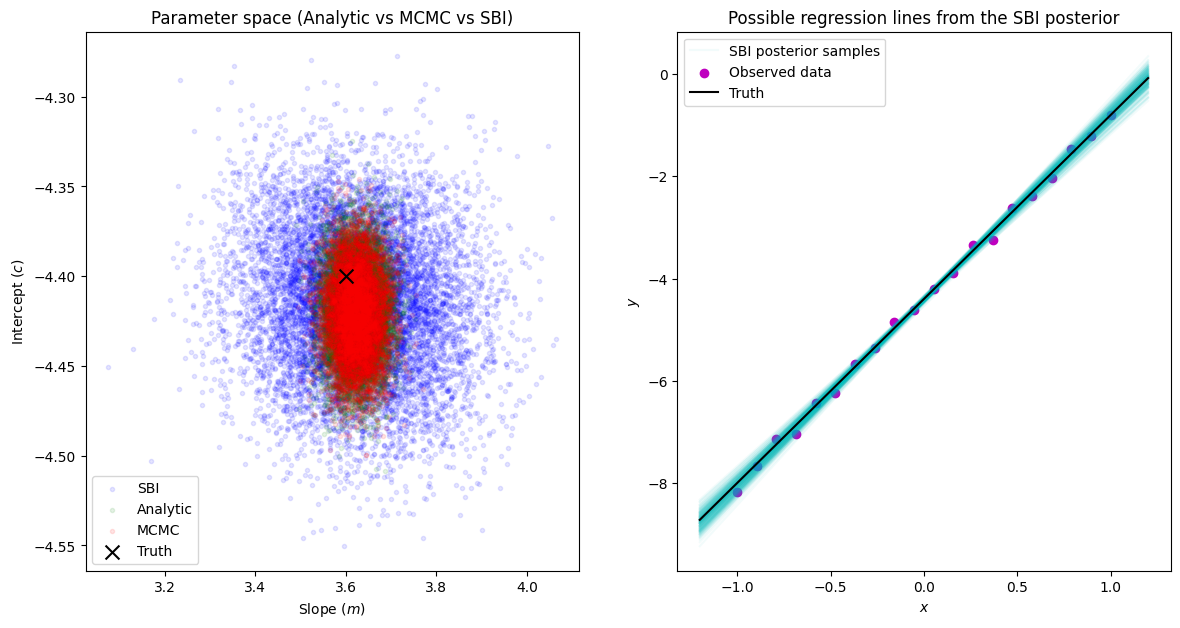

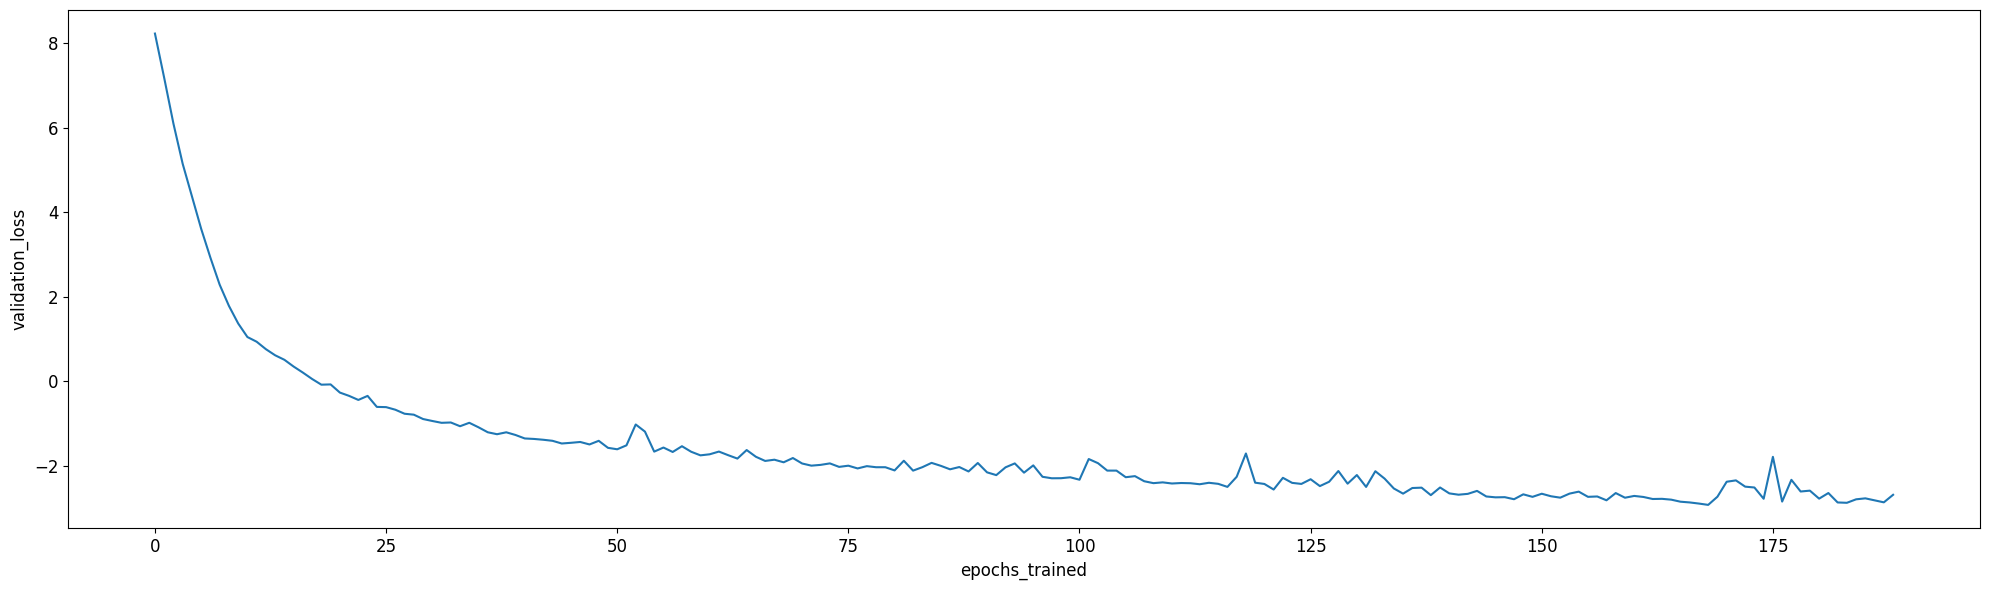

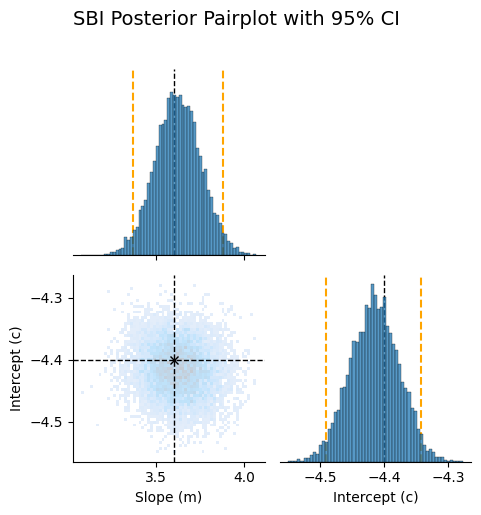

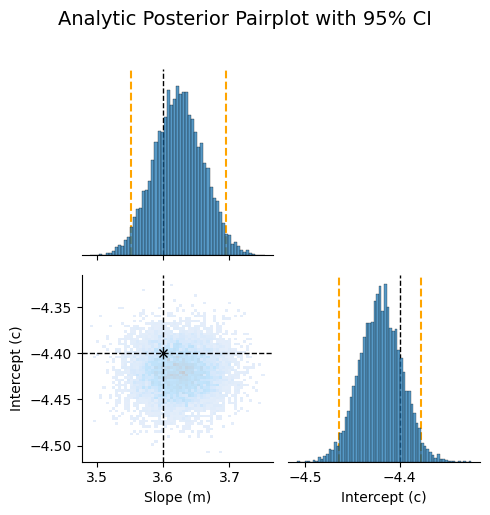

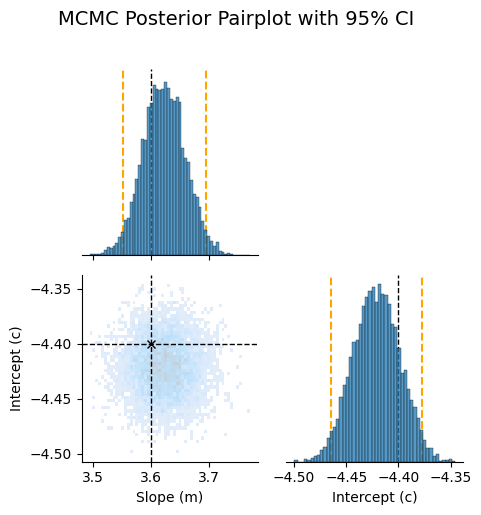

In [3]:
run_experiment()  # Default

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 62 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/kattheod/Documents/py4e/MachineLearning /sbi-logs/NPE_C/2025-05-24T22_07_38.483532' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


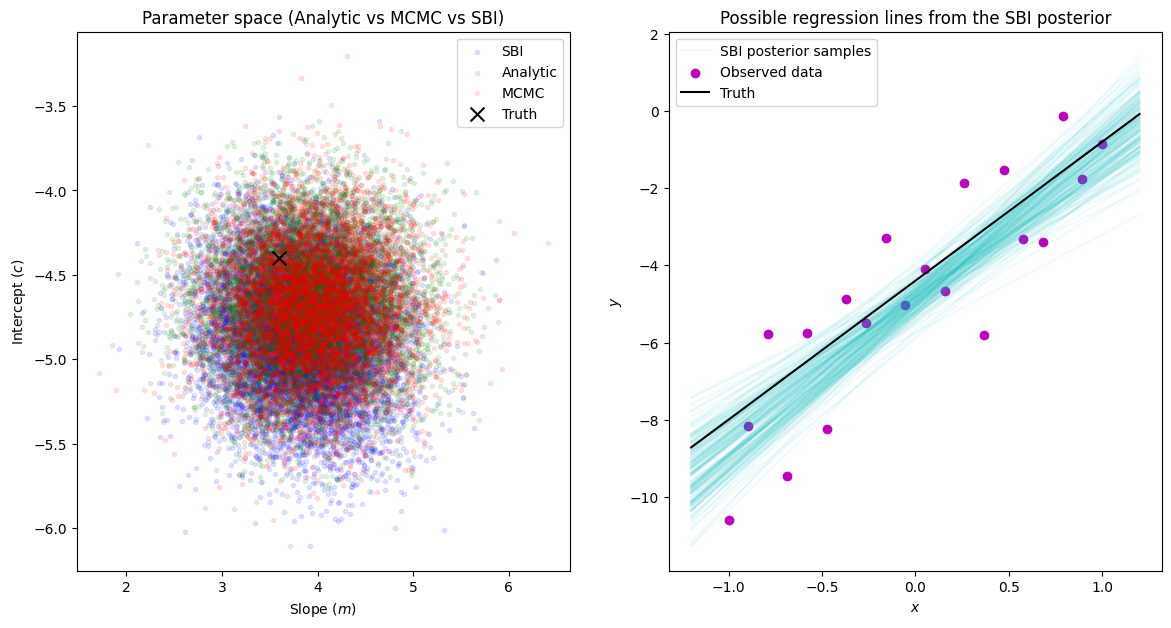

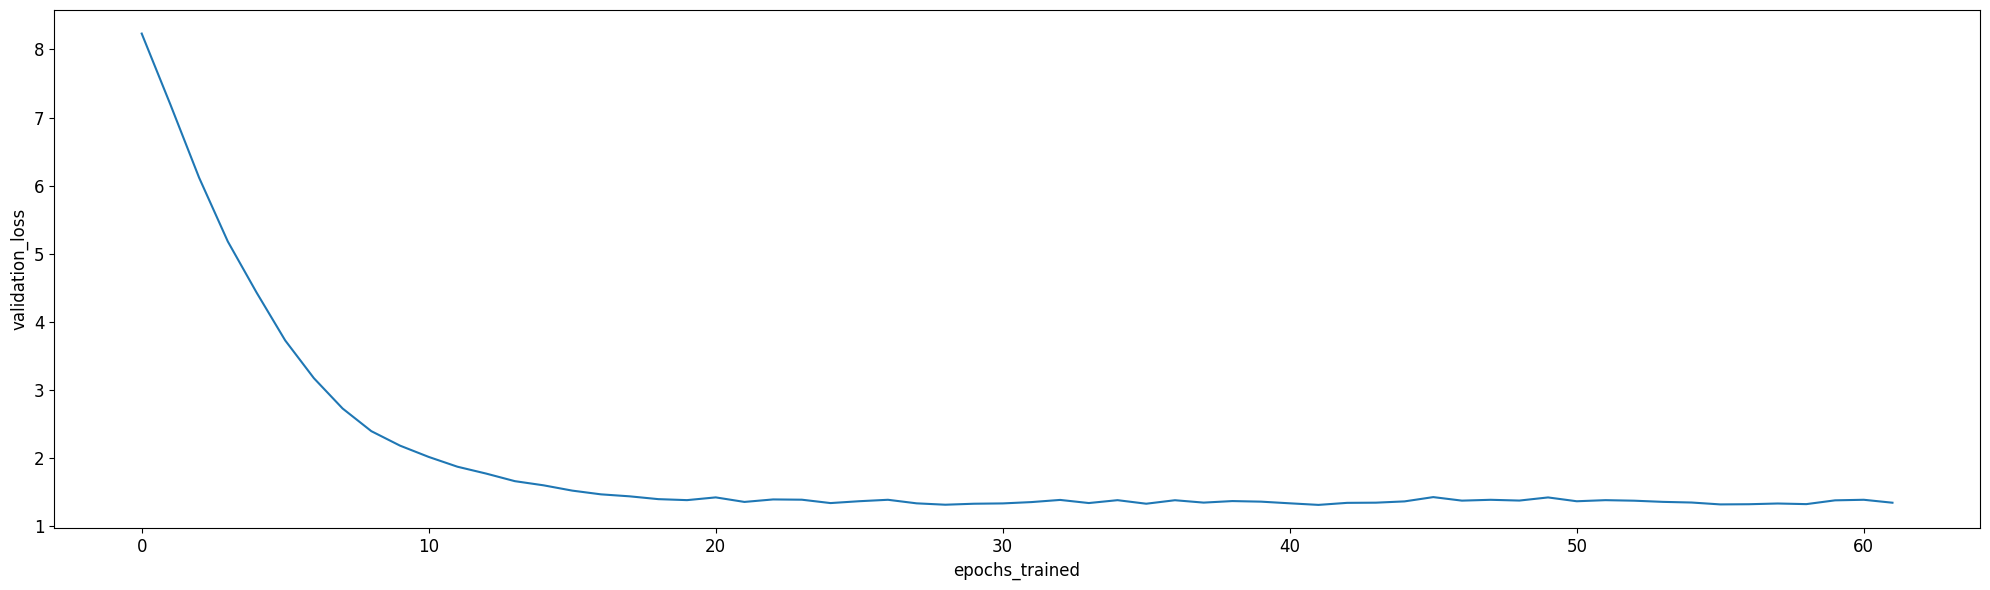

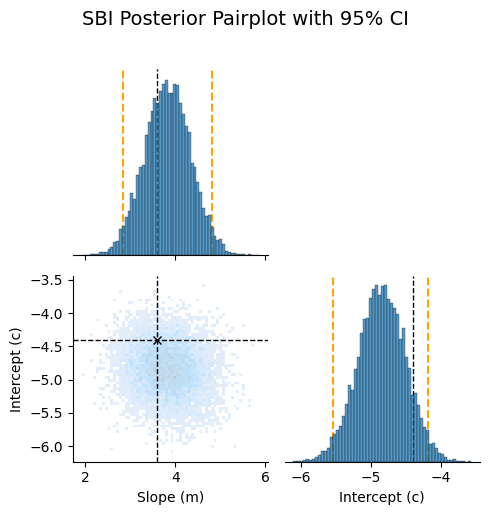

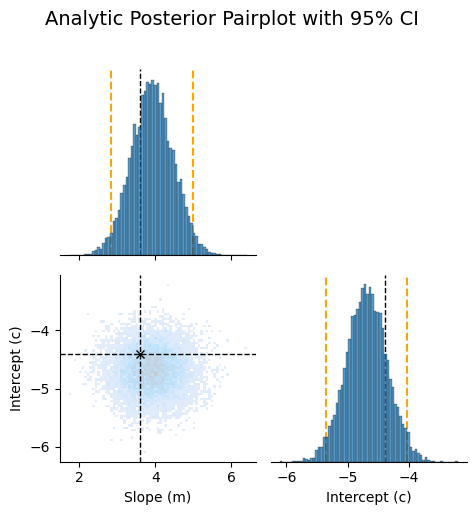

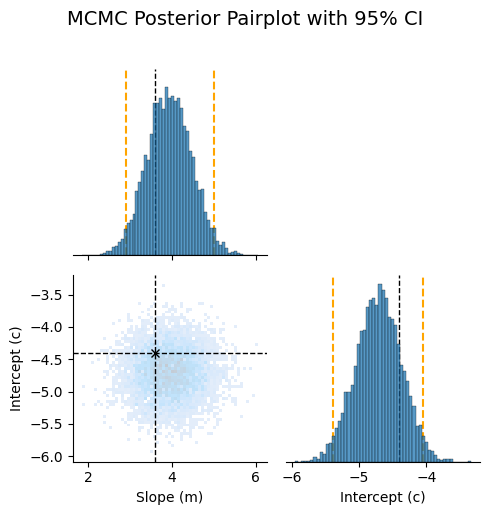

In [4]:
run_experiment(sigma_noise=1.5) # high noise

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 261 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/kattheod/Documents/py4e/MachineLearning /sbi-logs/NPE_C/2025-05-24T22_08_25.362460' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


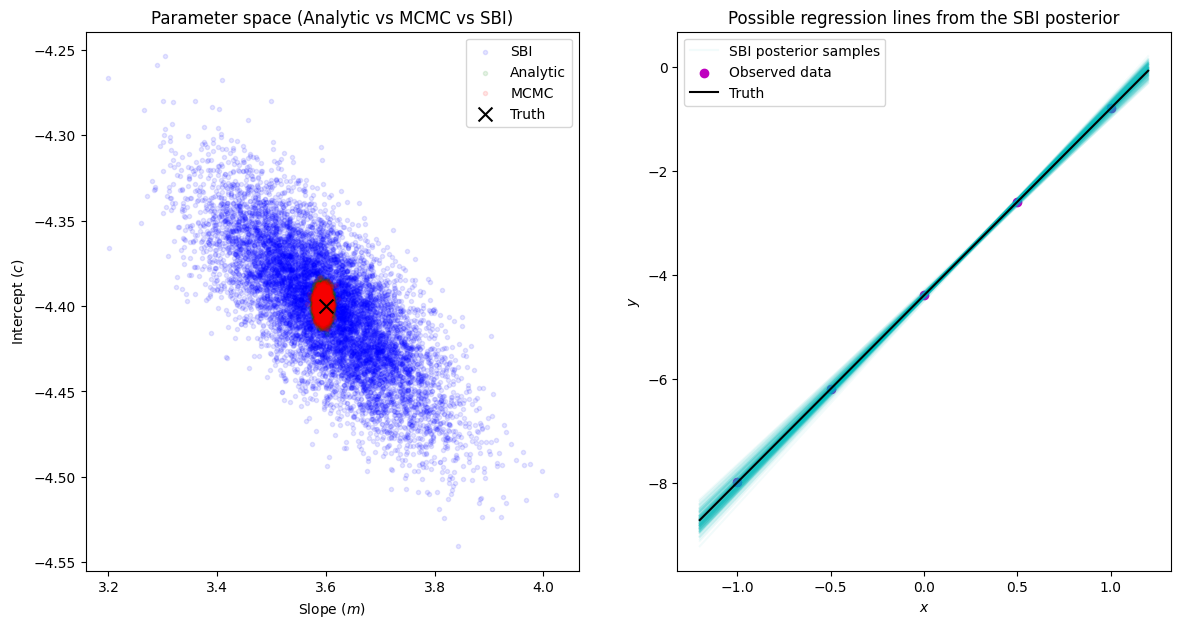

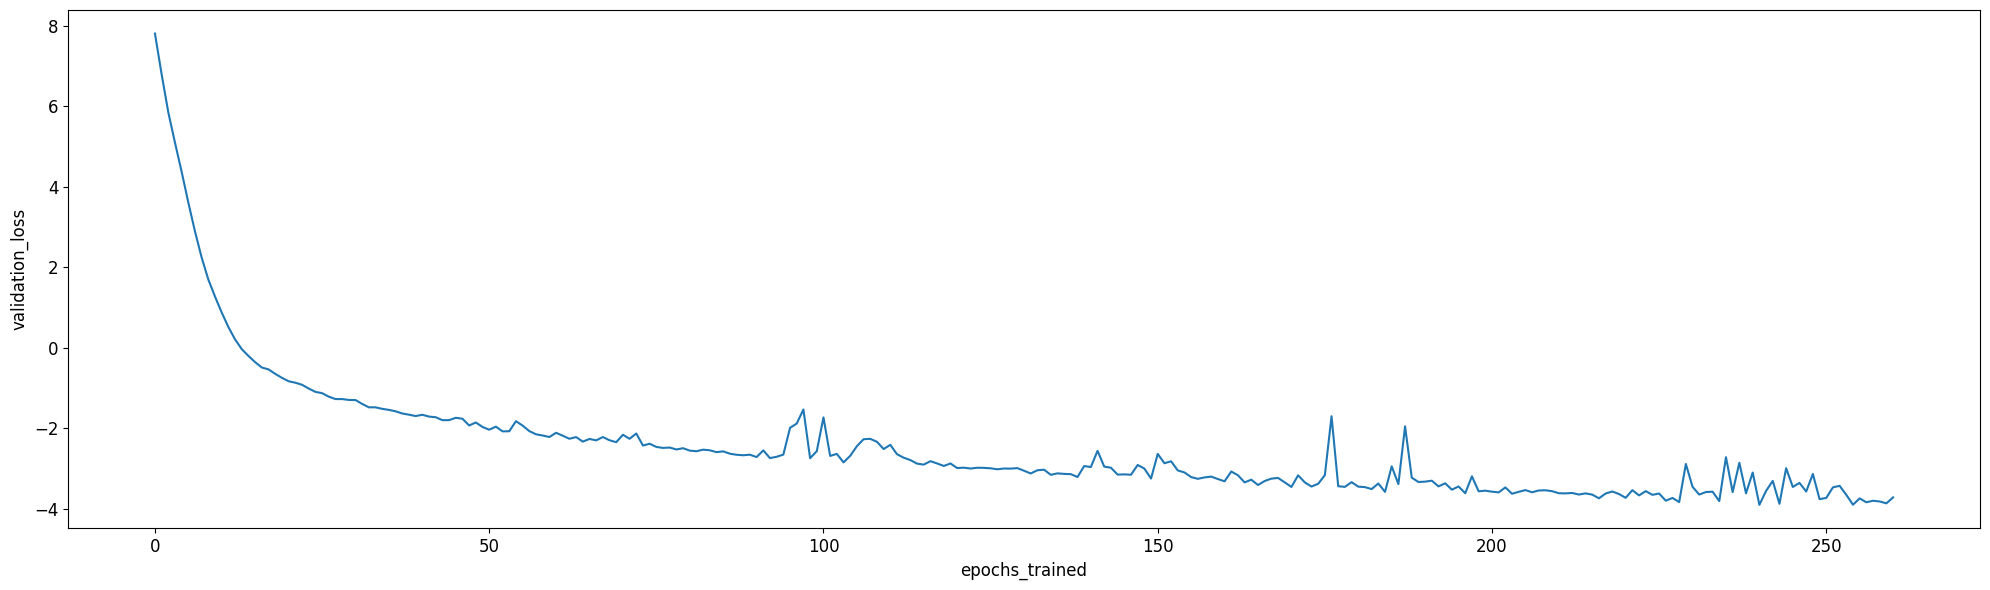

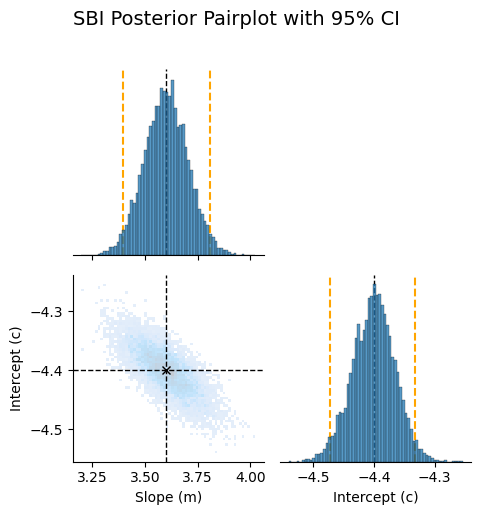

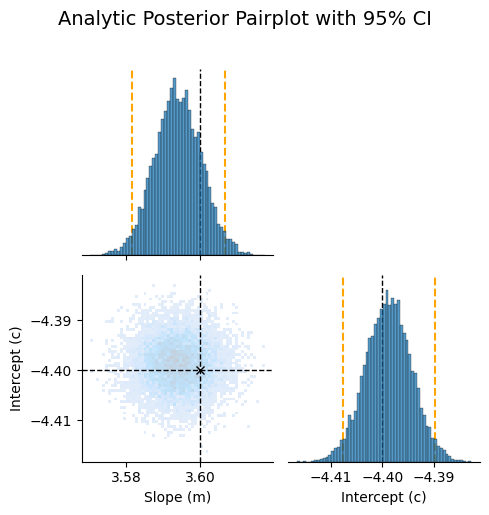

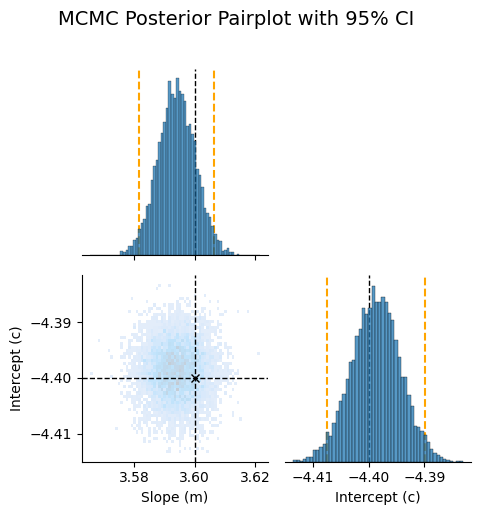

In [5]:
run_experiment(sigma_noise=0.01, n_grid=5) # low noise

  0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 112 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/kattheod/Documents/py4e/MachineLearning /sbi-logs/NPE_C/2025-05-24T22_09_14.357357' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


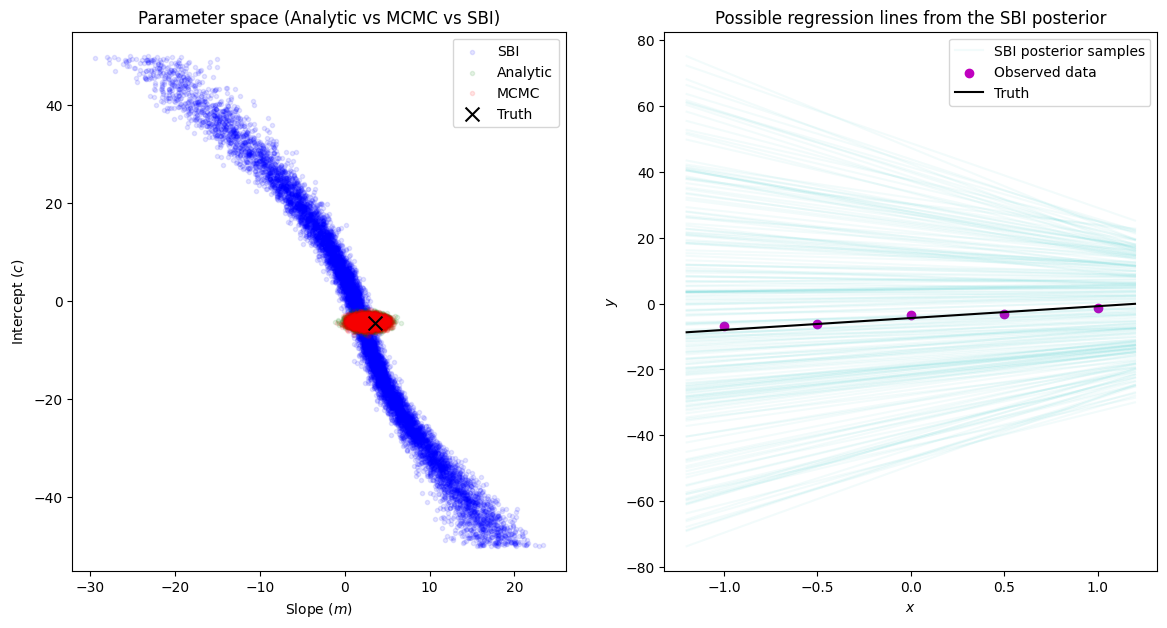

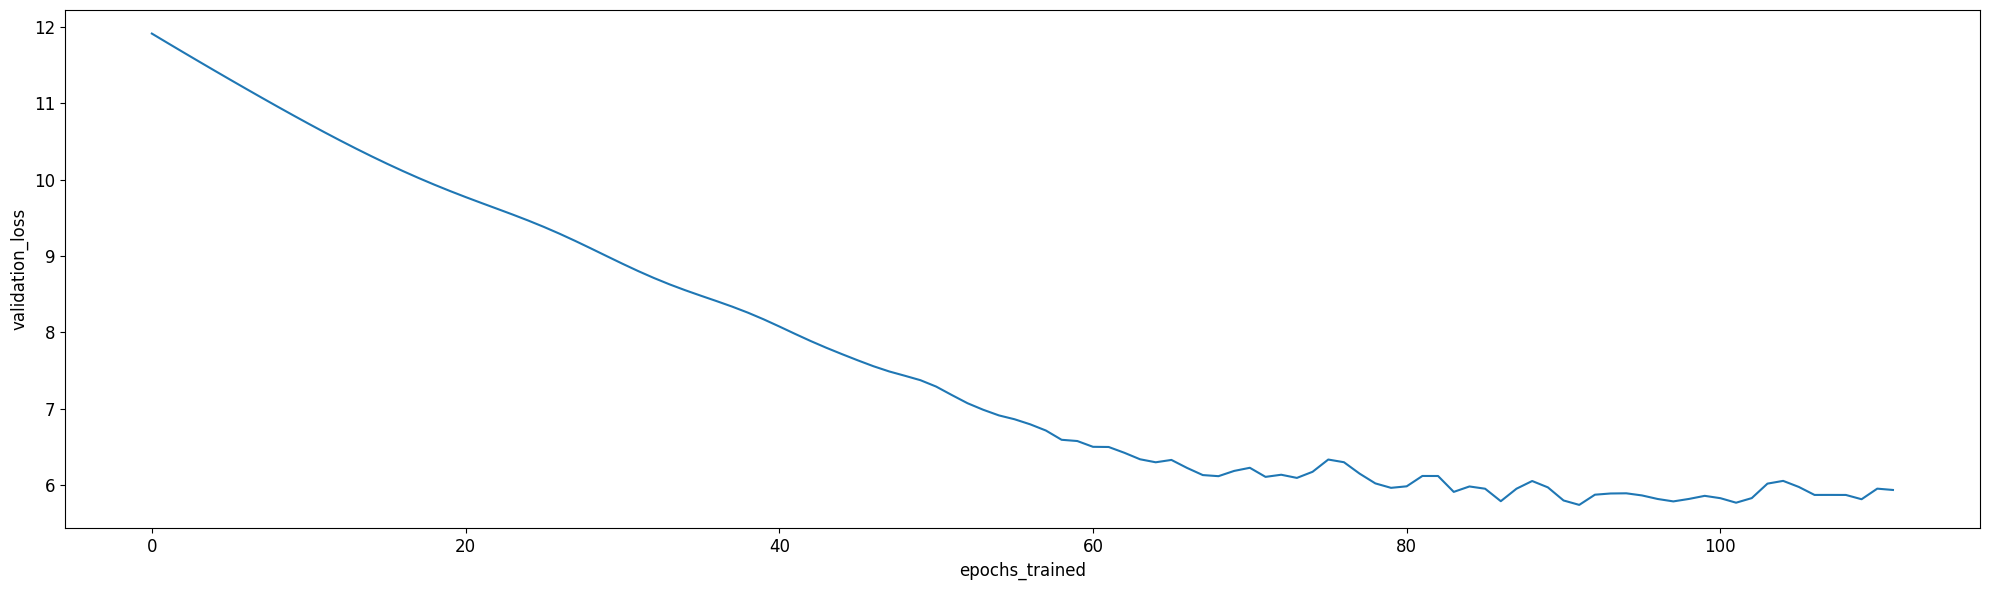

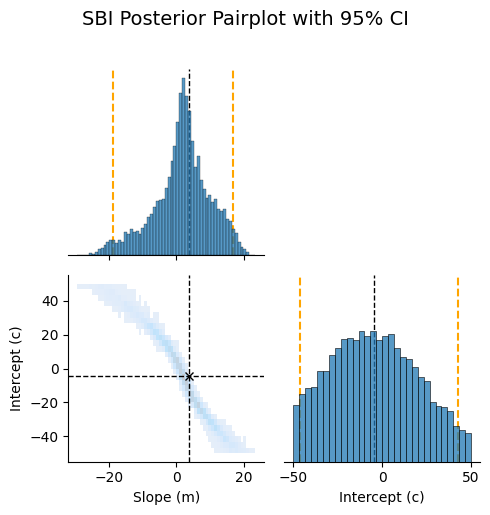

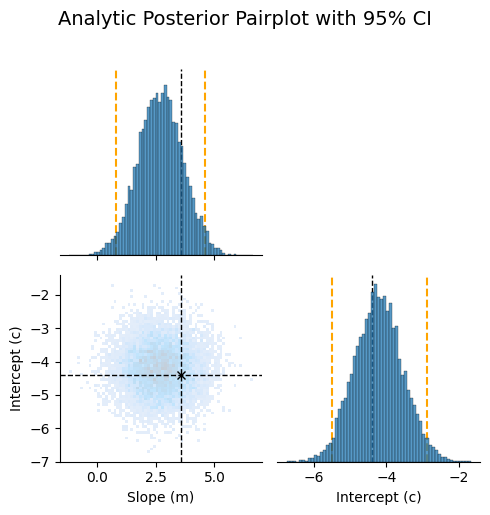

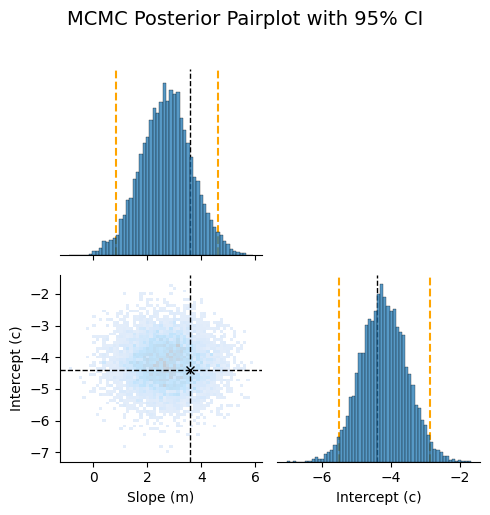

In [6]:
 run_experiment(
    theta_true=torch.tensor([3.6, -4.4]),
    sigma_noise=1.5,           # high noise
    n_grid=5,                  # very few data points
    x_domain=(-1.0, 1.0),
    prior_bounds=(-50.0, 50.0),  # very wide prior
    num_simulations=100,        # barely any training
    num_posterior_samples=10000,
    plot=True
)

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 332 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/kattheod/Documents/py4e/MachineLearning /sbi-logs/NPE_C/2025-05-19T22_37_04.201827' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


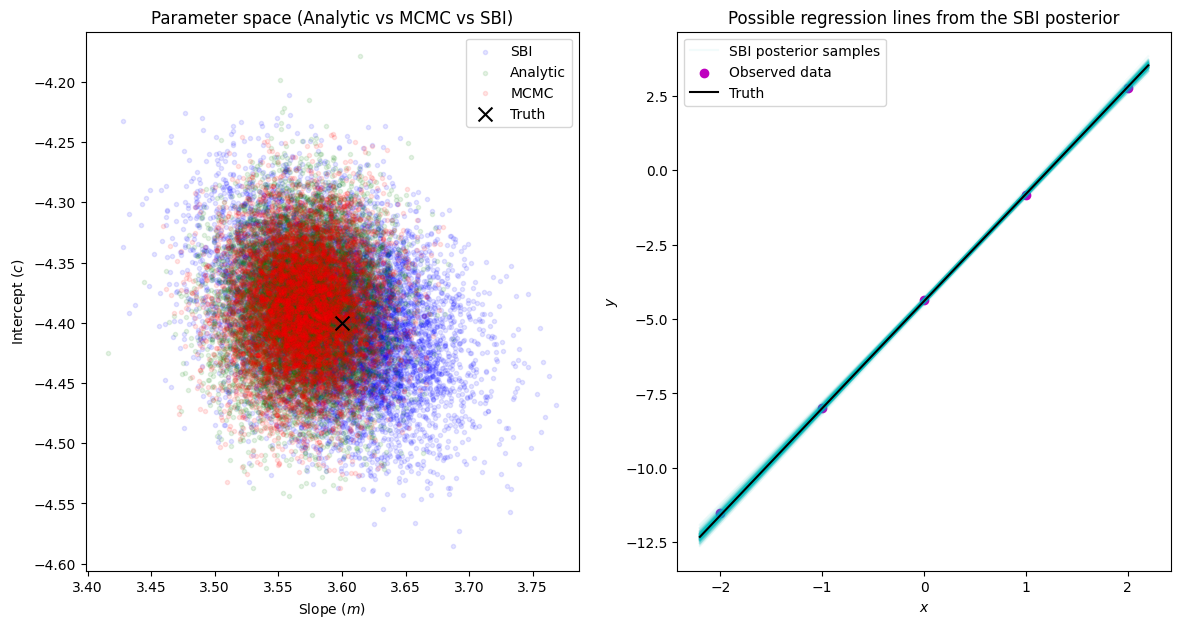

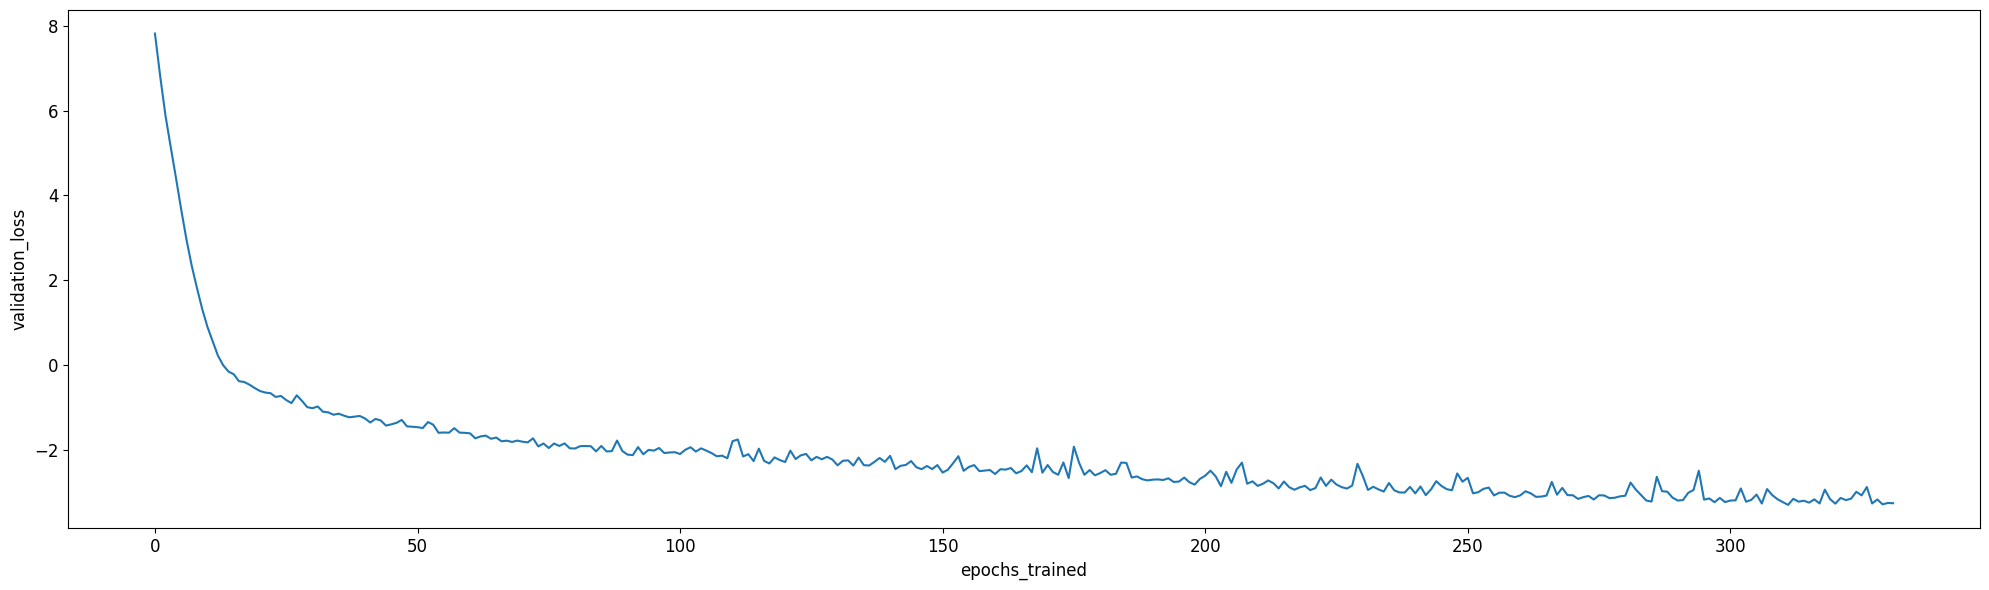

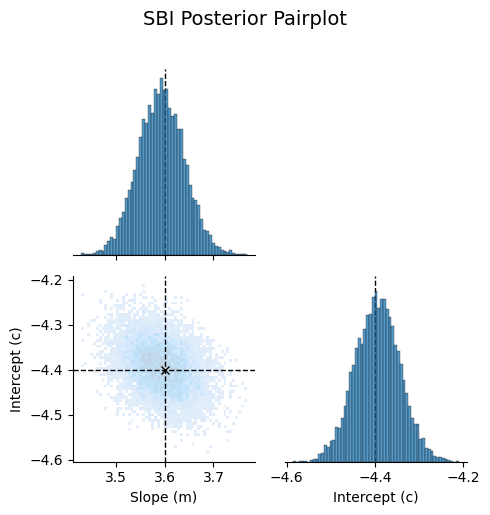

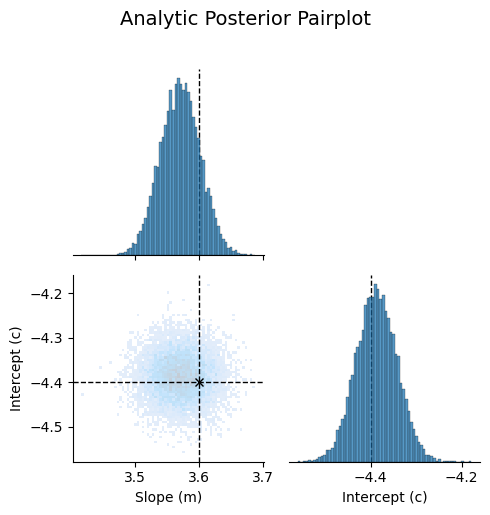

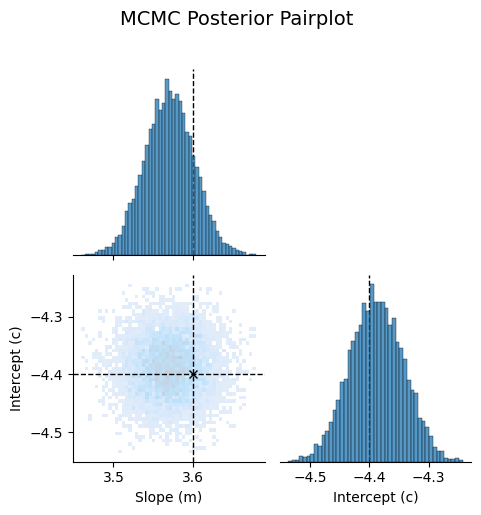

In [29]:
run_experiment(n_grid=5, x_domain=(-2, 2)) # sparse data

  0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 237 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, c]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/kattheod/Documents/py4e/MachineLearning /sbi-logs/NPE_C/2025-05-19T22_37_43.470158' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


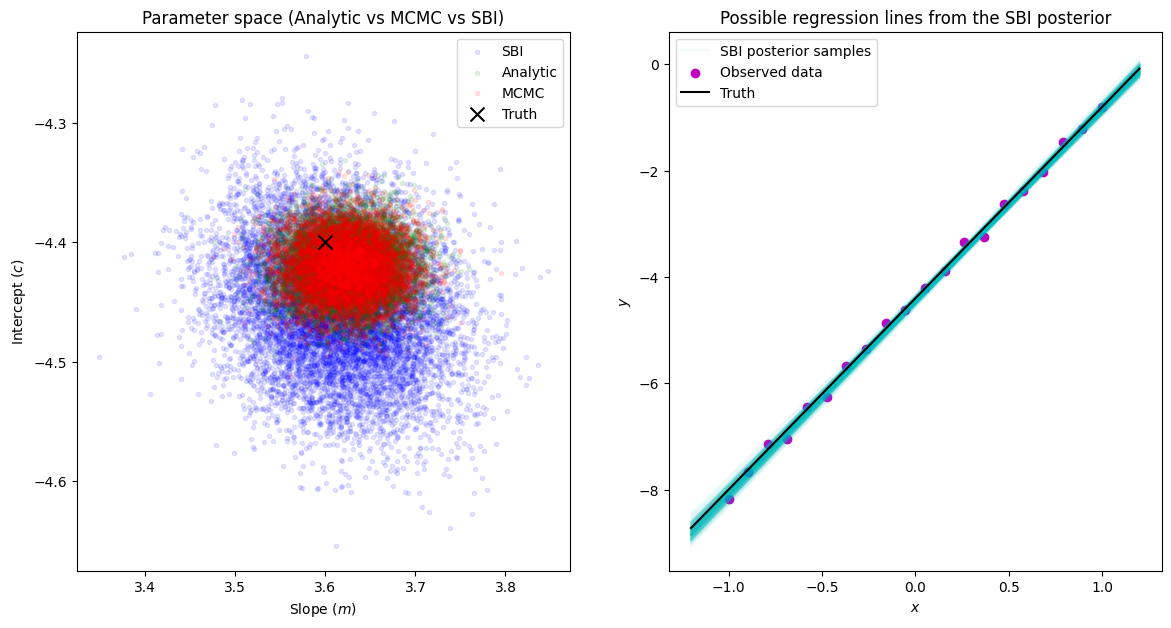

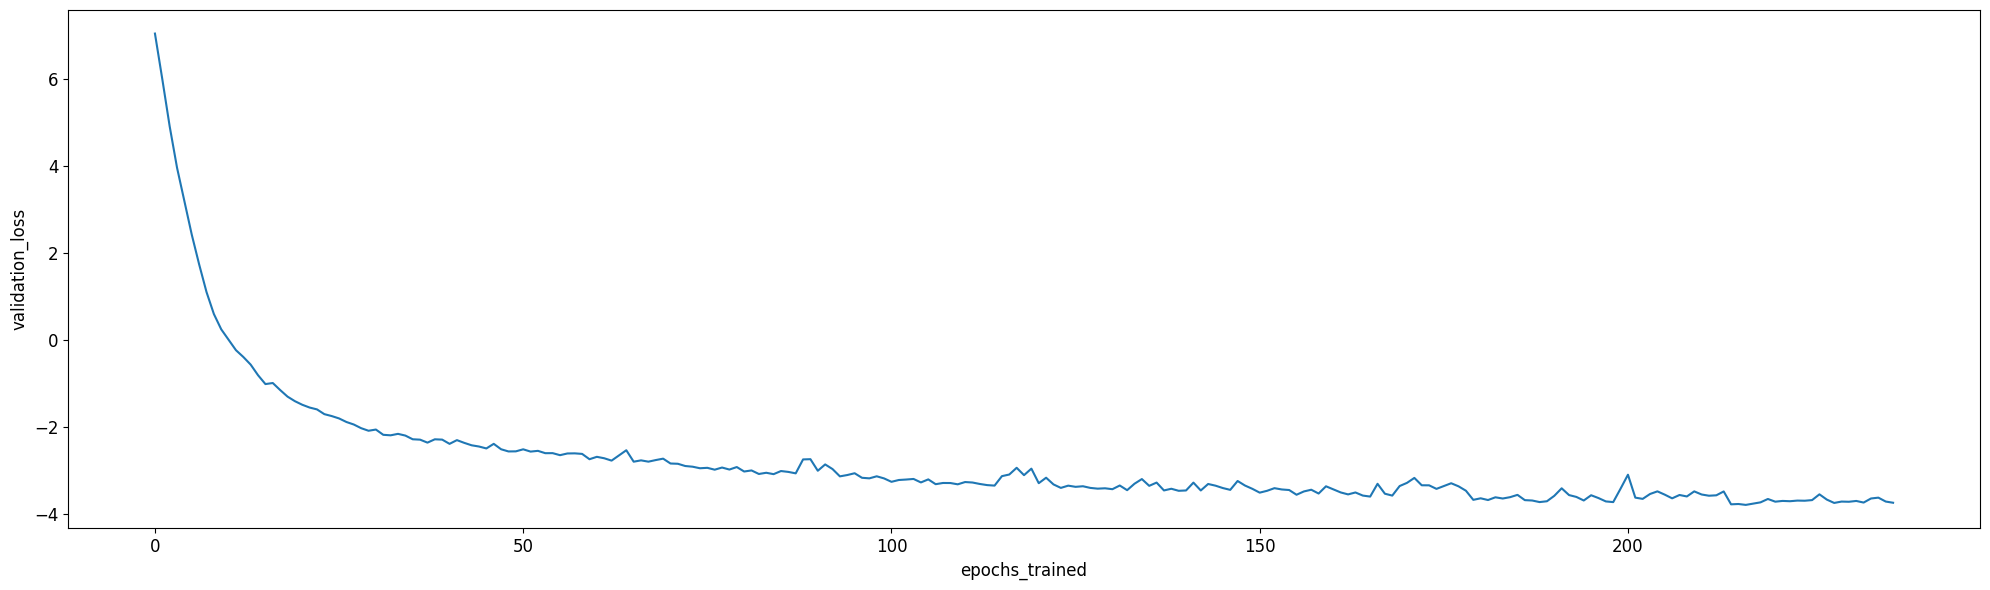

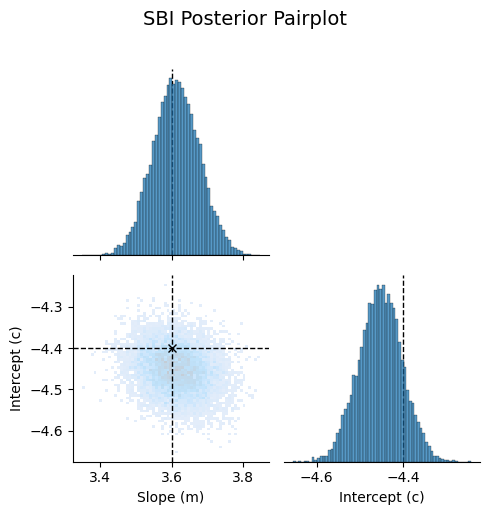

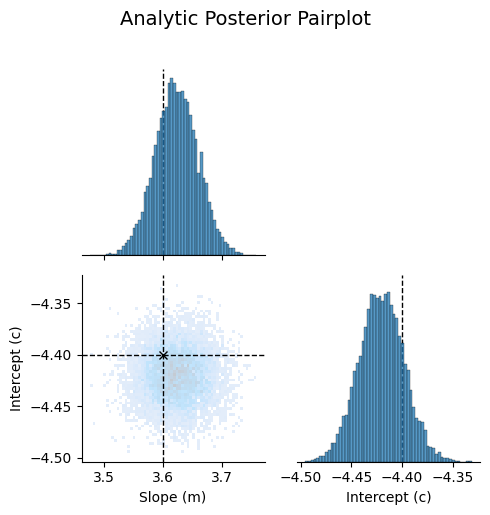

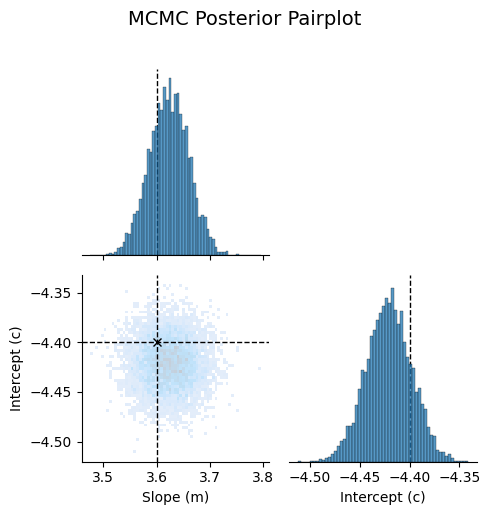

In [30]:
run_experiment(prior_bounds=(-5.0, 6.0)) # narrow, assymetric prior bounds